In [307]:
import sys
sys.path.append('../')
from src import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D
%matplotlib inline

Snippet to fit a model on a graph generated on the fly.

First, we generate a graph and the accompanying choice sets. In this case, we set $p=0.25$.

In [26]:
# generate a growing graph
(G, el) = network_generation.generate_mixed_model('test', n_max=20000, r=1.00, p=0.25, grow=True, m=4, vvv=1)
# compute choice sets
D = network_stats.choice_data('test', el, n_alt=8, vvv=1)

[test] generated a growing graph with 5004 nodes and 20001 edges (r=1.00, p=0.25)
[test] final graph has 5004 nodes and 20001 edges


Then, we try fitting a few different models.

## 1) Log Logit

In [3]:
# fit single log model
m1 = logit_individual.LogDegreeModel('test', D=D, vvv=2)
m1.fit()

[test] fitting with BFGS
[test] i=  0 ll=43945.18286
[test] parameters after fitting: [0.27484116]


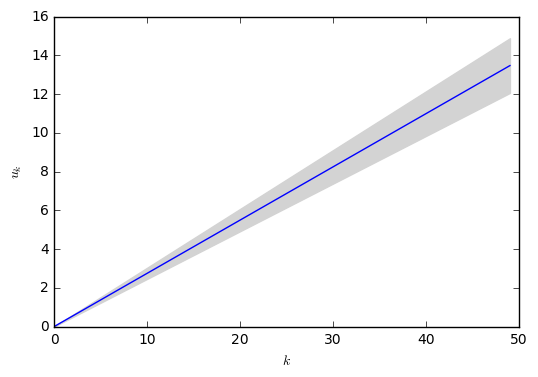

In [4]:
plt.figure()
xs = np.arange(50)
plt.fill_between(xs, xs * (m1.u - 1.96*m1.se), xs * (m1.u + 1.96*m1.se), color='lightgrey')
plt.plot(xs, xs * m1.u, '-b')
plt.xlabel(r"$k$")
plt.ylabel(r"$u_k$")

## 2) Degree Logit

In [5]:
# fit degree logit model
m2 = logit_individual.DegreeModel('test', D=D, vvv=2)
m2.fit()

[test] fitting with BFGS
[test] i=  0 ll=43826.10979
[test] i= 10 ll=43747.39013
[test] i= 20 ll=43738.43618
[test] i= 30 ll=43735.67776
[test] i= 40 ll=43735.47966
[test] i= 50 ll=43735.47943
[test] parameters after fitting: [1.         1.         0.41777652 1.88243385 0.45835985 0.50658657
 0.57074214 0.5688036  0.5960852  0.63282388 0.71623971 0.76042918
 0.73808792 0.76630077 0.77537738 0.93305778 0.88046373 0.81319014
 0.74974491 0.89872139 0.8613798  0.77208867 0.83499446 1.22390291
 0.76401985 1.30692439 1.0351824  1.1874997  0.92805813 1.11494596
 0.92813494 1.04220454 0.76654822 1.0155955  1.21814357 0.87148026
 1.36700307 1.04008241 0.89514831 1.41898992 1.29378986 0.68221412
 1.1846201  1.34665235 1.53580002 1.84975223 0.28011505 2.00750871
 1.30288824 1.30253973 1.95656809]


(0, 6)

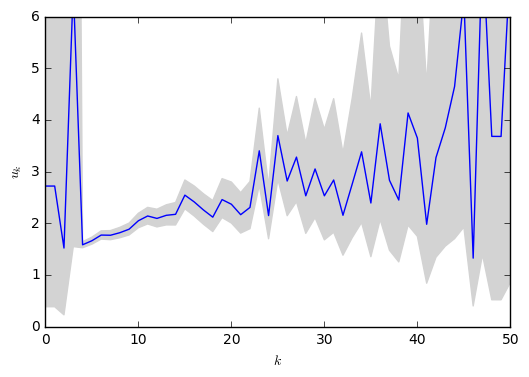

In [11]:
plt.figure()
xs = np.arange(51)
plt.fill_between(xs, np.exp(m2.u - 1.96*m2.se), np.exp(m2.u + 1.96*m2.se), color='lightgrey')
plt.plot(xs, np.exp(m2.u), '-b')
plt.xlabel(r"$k$")
plt.ylabel(r"$u_k$")
axes = plt.gca()
axes.set_ylim([0, 6])

The fit isn't great as there isn't much data in the higher degree region.

## 3) Mixed Logit

In [369]:
# fit mixed logit model
m3 = logit.MixedLogitModel('test', grouped=False, D=D, vvv=1)
m3.add_log_degree_model()
m3.add_uniform_degree_model()
T3 = m3.fit(etol=0.0001, n_rounds=5000, return_stats=True)

[test] [  0/5000] (ld) pi_1=0.484 u_1=0.71 ll_1=20706.48 (ud) pi_2=0.516 u_2=1.00 ll_2=22658.18 (*) tot_ll=43364.6611
[test] [ 10/5000] (ld) pi_1=0.476 u_1=0.47 ll_1=20684.04 (ud) pi_2=0.524 u_2=1.00 ll_2=23008.00 (*) tot_ll=43692.0439
[test] [ 20/5000] (ld) pi_1=0.477 u_1=0.47 ll_1=20701.17 (ud) pi_2=0.523 u_2=1.00 ll_2=22991.22 (*) tot_ll=43692.3948
[test] [4980/5000] (ld) pi_1=0.595 u_1=0.38 ll_1=25928.40 (ud) pi_2=0.405 u_2=1.00 ll_2=17809.27 (*) tot_ll=43737.6710
[test] [4990/5000] (ld) pi_1=0.595 u_1=0.38 ll_1=25935.27 (ud) pi_2=0.405 u_2=1.00 ll_2=17802.45 (*) tot_ll=43737.7198
[test] u's  = [(ld:0.383), (ud:1.000)]
[test] pi's = [(ld:0.595), (ud:0.405)]


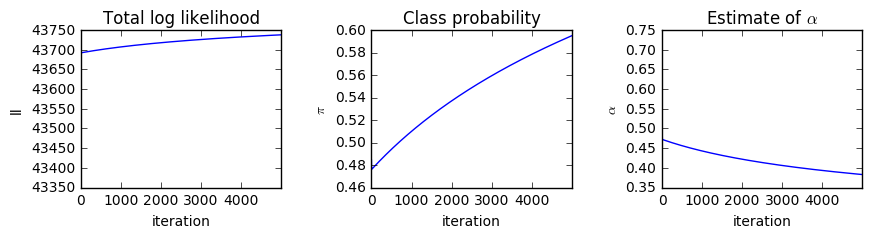

In [370]:
def res_plot(T):
    plt.figure(figsize=(9,2.5))
    
    plt.subplot(131)
    T.tot_ll.plot()
    plt.title('Total log likelihood')
    plt.xlabel("iteration")
    plt.ylabel("ll")
    
    plt.subplot(132)
    T.p1.plot()
    plt.title('Class probability')
    plt.xlabel("iteration")
    plt.ylabel(r"$\pi$")
    
    plt.subplot(133)
    T.u1.plot()
    plt.title(r'Estimate of $\alpha$')
    plt.xlabel("iteration")
    plt.ylabel(r"$\alpha$")
    
    plt.tight_layout()
    
res_plot(T3)

* It converges quite quickly with respect to total log likelihood.
* The class probability doesn't change at all, and stays at 0.48.
* The estimate for $\alpha$ stops at 0.6.

Here, we plot the path through the parameter space:

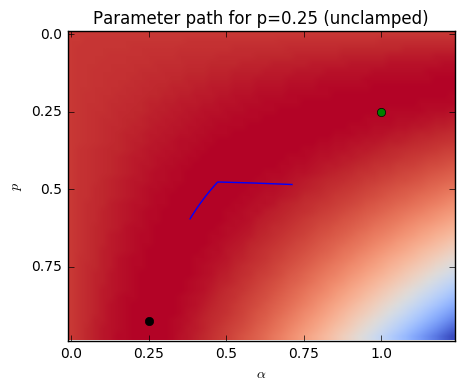

In [371]:
step = 0.025
Z = make_z(D)  # from p=0.25
f, ax = plt.subplots()
plot_ll_heatmap(ax, Z, 0.25, title="Parameter path for p=0.25 (unclamped)", step=step)
plt.plot((1.25/step)/5 * T3.u1 * 4, (1.00/step)/4 * T3.p1 * (1/0.25), '-b')

## 3b) Mixed Logit with clamped coefficients

Here, we 'clamp' the $\alpha$ coefficient. We set it to 1 (pure PA) and do not update it in between iterations of EM. All that changes is the class probabilities.

In [319]:
# fit mixed logit model
m3b = logit.MixedLogitModel('test', grouped=False, D=D, vvv=1)
m3b.add_log_degree_model(bounds=((1, 1),))  # clamped at 1 (full PA)
m3b.add_uniform_degree_model()
T3b = m3b.fit(etol=0.025, n_rounds=200, return_stats=True)

[test] [  0/200] (ld) pi_1=0.484 u_1=1.00 ll_1=20803.03 (ud) pi_2=0.516 u_2=1.00 ll_2=22658.18 (*) tot_ll=43461.2171
[test] [ 10/200] (ld) pi_1=0.369 u_1=1.00 ll_1=15640.54 (ud) pi_2=0.631 u_2=1.00 ll_2=27728.28 (*) tot_ll=43368.8199
[test] [ 20/200] (ld) pi_1=0.306 u_1=1.00 ll_1=12875.24 (ud) pi_2=0.694 u_2=1.00 ll_2=30493.54 (*) tot_ll=43368.7784
[test] [ 30/200] (ld) pi_1=0.270 u_1=1.00 ll_1=11332.07 (ud) pi_2=0.730 u_2=1.00 ll_2=32053.03 (*) tot_ll=43385.1085
[test] [ 40/200] (ld) pi_1=0.249 u_1=1.00 ll_1=10424.91 (ud) pi_2=0.751 u_2=1.00 ll_2=32975.56 (*) tot_ll=43400.4699
[test] [ 50/200] (ld) pi_1=0.237 u_1=1.00 ll_1=9869.55 (ud) pi_2=0.763 u_2=1.00 ll_2=33542.50 (*) tot_ll=43412.0478
[test] [ 60/200] (ld) pi_1=0.228 u_1=1.00 ll_1=9519.74 (ud) pi_2=0.772 u_2=1.00 ll_2=33900.46 (*) tot_ll=43420.2050
[test] [ 70/200] (ld) pi_1=0.223 u_1=1.00 ll_1=9295.10 (ud) pi_2=0.777 u_2=1.00 ll_2=34130.70 (*) tot_ll=43425.8002
[test] [ 80/200] (ld) pi_1=0.220 u_1=1.00 ll_1=9148.95 (ud) pi_2=0.

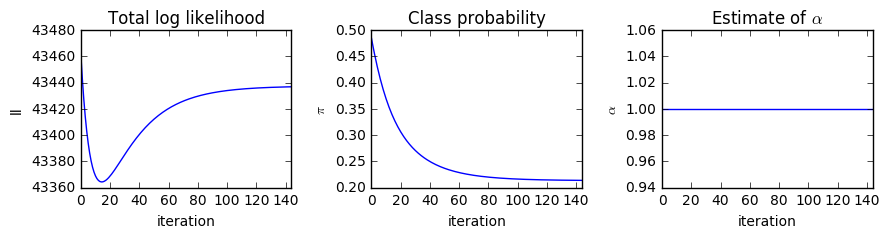

In [365]:
res_plot(T3b)

* The log likelihood is non-monotonic in the first 15 rounds, but then converges (albeit very slowly).
* The class probability converges to 0.277, which is slightly biased, but better than the Log Logit estimate of 0.289.
* $\alpha$ is clamped at 1, so it doesn't change.

Here, we plot the path through the parameter space (remember, $\alpha$ is clamped to 1).

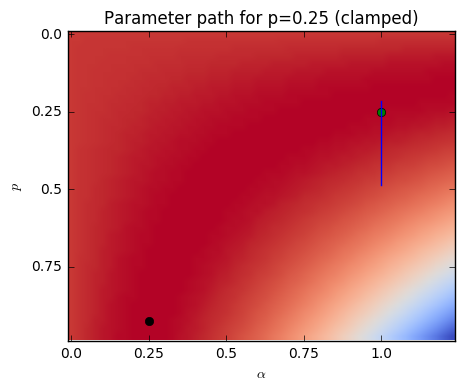

In [338]:
step = 0.025
Z = make_z(D)  # from p=0.25
f, ax = plt.subplots()
plot_ll_heatmap(ax, Z, 0.25, title="Parameter path for p=0.25 (clamped)", step=step)
plt.plot((1.25/step)/5 * T3b.u1 * 4, (1.00/step)/4 * T3b.p1 * (1/0.25), '-b')

## 4) Manual evaluation of the LL function

Here is code tocompute the LL manually for specific values of $\alpha$ (equal to $u$) and $p$ (equal to $\pi$), and to make a surface plot of the resulting values.

In [299]:
from matplotlib import gridspec

def make_z(D, step=0.025):
    alphas = np.arange(0.0, 1.25, step)
    ps = np.arange(0.0, 1.0, step)
    X, Y = np.meshgrid(alphas, ps)
    # apply util.manual_ll to each value of (alpha, p)
    # ideally, we'd use np.vectorize(util.manual_ll, excluded=['D']),
    # but this doesn't seem to work, so on to a more hacky solution
    Z = np.sqrt(X**2 + Y**2)  # to initialize the meshgrid
    scores_uniform = np.array(1.0 / D.groupby('choice_id')['y'].aggregate(len))
    for i in range(len(alphas)):
        alpha = alphas[i]
        D['score'] = np.exp(alpha * np.log(D.deg + util.log_smooth))
        score_tot = D.groupby('choice_id')['score'].aggregate(np.sum)
        scores_pa = np.array(D.loc[D.y == 1, 'score']) / np.array(score_tot)
        for j in range(len(ps)):
            p = ps[j]
            scores = p * scores_pa + (1 - p) * scores_uniform
            Z[j, i] = sum(np.log(scores + util.log_smooth))
            # old: Z[j, i] = util.manual_ll(D, alpha, p)
    return Z

def plot_ll_surface(ax, Z, actual_p, title="Log-likelihood", step=0.025):
    alphas = np.arange(0.0, 1.25, step)
    ps = np.arange(0.0, 1.0, step)
    X, Y = np.meshgrid(alphas, ps)
    i,j = np.unravel_index(Z.argmax(), Z.shape)  # get empirical maximum
    # make the plot
    ax.view_init(elev=40, azim=320)
    ax.dist = 12
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$p$')
    ax.set_zlabel('LL')
    ax.plot([alphas[j]]*2, [ps[i]]*2, ax.get_zlim(), 'black')   # empirical max
    ax.plot([1]*2, [actual_p]*2, ax.get_zlim(), 'green')  # actual
    ax.set_title(title)

def plot_ll_heatmap(ax, Z, actual_p, title="Log-likelihood", step=0.025):
    alphas = np.arange(0.0, 1.25, step)
    ps = np.arange(0.0, 1.0, step)
    X, Y = np.meshgrid(alphas, ps)
    i,j = np.unravel_index(Z.argmax(), Z.shape)  # get empirical maximum
    # make the plot
    ax.imshow(Z, cmap=cm.coolwarm)
    ax.set_xticks(np.arange(0, (1.25/step) + 0.05, (1.25/step)/5))
    ax.set_xticklabels(np.arange(0.0, 1.2505, 0.25))
    ax.set_yticks(np.arange(0,  (1.0/step) + 0.05, (1.00/step)/4))
    ax.set_yticklabels(np.arange(0.0, 1.05, 0.25))
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$p$')
    ax.plot((1.25/step)/5 * 4,
            (1.00/step)/4 * actual_p * (1/0.25),
            'o', color='green')  # actual
    ax.plot(j, i, 'o', color='black')  # empirical max
    ax.set_title(title)

def make_both_plot(Z, actual_p, step=0.025):
    fig = plt.figure(figsize=(10, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 1]) 
    # make the surface plot
    ax = fig.add_subplot(gs[0], projection='3d')
    plot_ll_surface(ax, Z, 0.25, title=r"LL Surface for ($\alpha$=1, $p$=%.2f)" % 0.25)
    # make heatmap
    ax = fig.add_subplot(gs[1])
    plot_ll_heatmap(ax, Z, 0.25, title=r"LL Surface for ($\alpha$=1, $p$=%.2f)" % 0.25)
    fig.show()
    

First we run it on our running example.
The black dot is the empirical maximum and the green dot represents the actual value.

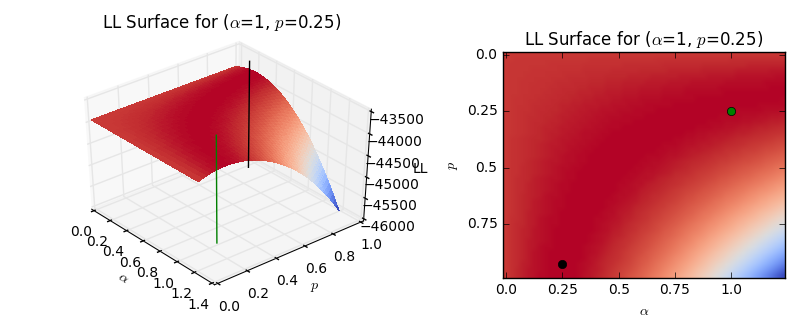

In [300]:
Z = make_both_plot(D)
make_3d_plot(Z, 0.25)

Here is how to do the function call with the EM framework

In [19]:
# fit mixed logit model
m3c = logit.MixedLogitModel('test', grouped=False, D=D, vvv=1)
m3c.add_log_degree_model(bounds=((1, 1),))
m3c.add_uniform_degree_model()
# evaluate LL for u = 1 and alpha = 0.25
m3c.ll_pi({0: [1], 1: [1]}, {0: 0.25, 1: 0.75})

43352.54602569292

Here we run the same code on the graphs we generated before. I show the LL surface for all graphs with $r=1$, with only $p$ varying. In all cases $\alpha=1$. I show the results on both simulated growing and densifying graphs.

Again, the black dot is the empirical maximum and the green dot represents the actual value.

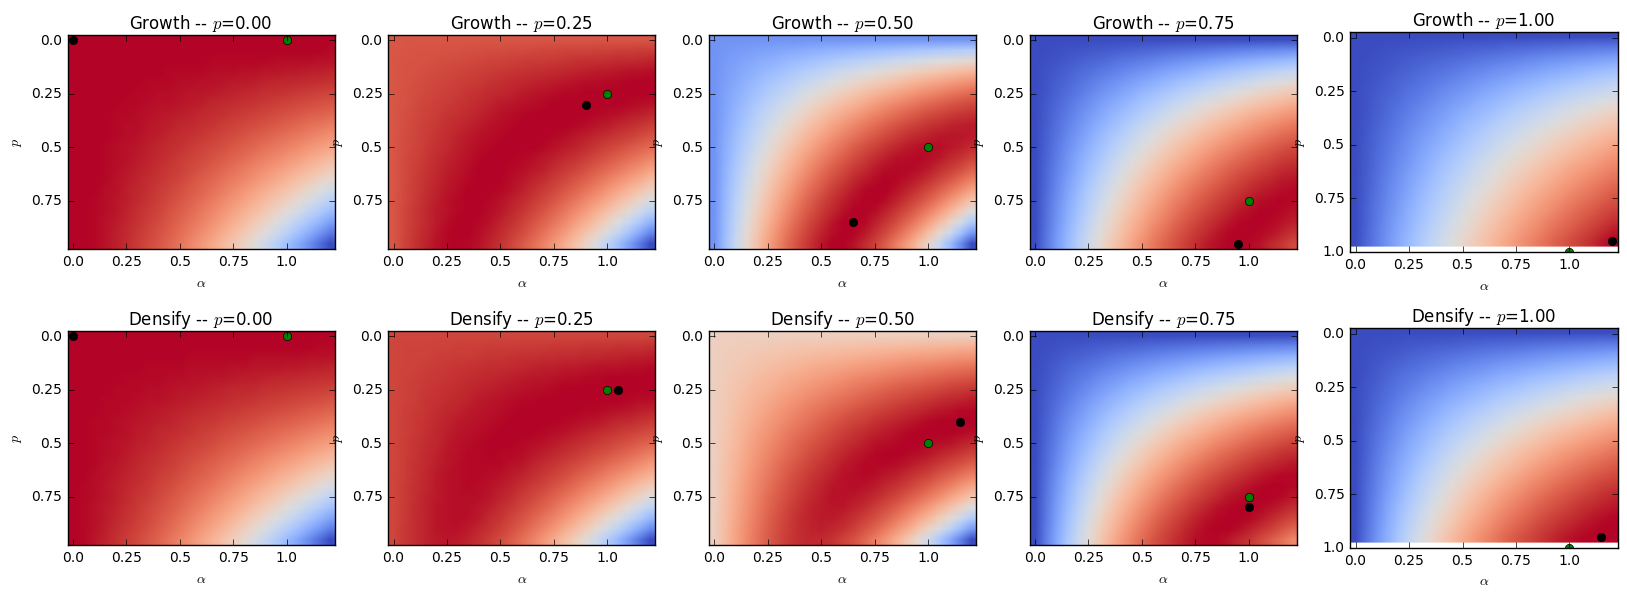

In [311]:
fig = plt.figure(figsize=(20, 7))
gs = gridspec.GridSpec(2, 5)
i = 0
step = 0.05
for t in ['g','d']:
    for p in [0, 0.25, 0.5, 0.75, 1]:
        Dt = util.read_individual_data_single('%s-1.00-%.2f-00.csv' % (t, p))
        Zt = make_z(Dt, step=step)
        ax = fig.add_subplot(gs[i])
        title = r"%s -- $p$=%.2f" % ("Growth" if t=='g' else "Densify", p)
        plot_ll_heatmap(ax, Zt, p, title=title, step=step)
        i += 1
fig.show()

Here are some observations:
* when $p=0$, any $\alpha$ gives equivalent results. Similarly, if $\alpha=0$, $p$ doesn't matter.
* with a non-trivial $p$, there is an approximate trade-off between $p$ and $\alpha$, where an increase in $p$ gets paired with a decrease in $\alpha$. This leads to large regions with very similar likelihoods, especially for low $p$. 
* For densifying graphs, the empirical maximum is still close to the actual parameter values, but for growing graphs less so. This could be due to the larger number of choices sets with fewer choices and less inequality in the degrees.
* with $p=1$, it looks like $\alpha$ gets overestimated. This happens slightly more so in the growing graphs. I'm not sure why this would be.

## 5) Likelihood while $n$ increases

Here we plot the likelihood surface as $n$ increases.

In [347]:
# generate graphs
ns = [100, 1000, 5000, 10000, 50000]
Ds = []
for i in range(len(ns)):
    print(ns[i])
    (G, el) = network_generation.generate_mixed_model('test', n_max=ns[i], r=1.00, p=0.5, grow=True, m=4, vvv=0)
    Ds.append(network_stats.choice_data('test', el, n_alt=5, vvv=0))

100
1000
5000
10000
50000


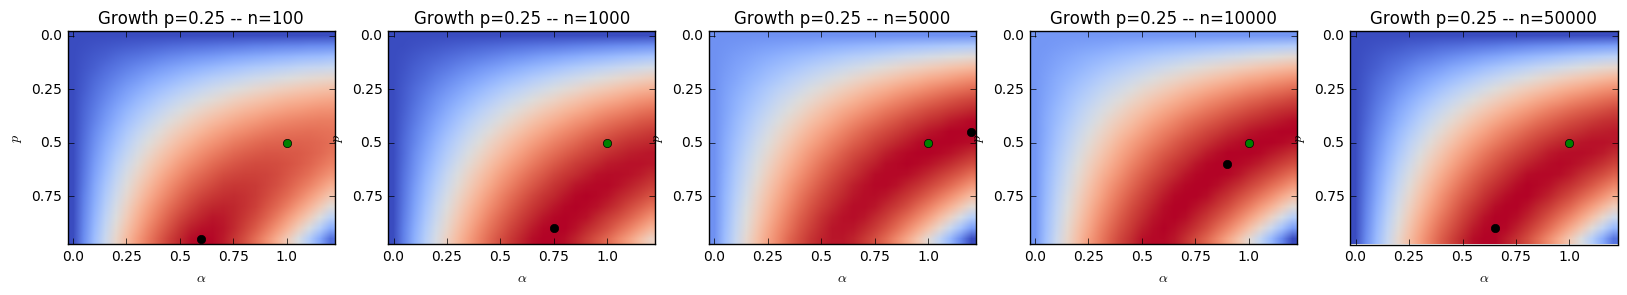

In [348]:
fig = plt.figure(figsize=(20, 3.5))
gs = gridspec.GridSpec(1, 5)
for i in range(len(ns)):
    Zt = make_z(Ds[i], step=0.05)
    ax = fig.add_subplot(gs[i])
    title = r"Growth p=0.25 -- n=%d" % ns[i]
    plot_ll_heatmap(ax, Zt, 0.5, title=title, step=0.05)
fig.show()

## 6) Rescale negative samples

Following formula 10 from page 11 of the [Word2Net](https://openreview.net/pdf?id=SkJd_y-Cb) paper, we try rescaling the negative samples with $\frac{V-1}{|S_n|}$, where $V$ is the size of the full choice set (so the number of nodes that the node is not connected to) and $|S_n|$ is the size of the negatively sampled set. In our case this is usually 8. The first set of plots reads a data set ($p=0.25$ still) and fits it without rescaling the negative samples, and the second set shows it with rescaling.

[g-1.00-0.25-00.csv] read (192456 x 4)
[g-1.00-0.25-00.csv] [  0/200] (ld) pi_1=0.487 u_1=1.00 ll_1=19859.43 (ud) pi_2=0.513 u_2=1.00 ll_2=21536.20 (*) tot_ll=41395.6308
[g-1.00-0.25-00.csv] [ 10/200] (ld) pi_1=0.390 u_1=1.00 ll_1=15726.66 (ud) pi_2=0.610 u_2=1.00 ll_2=25609.38 (*) tot_ll=41336.0355
[g-1.00-0.25-00.csv] [ 20/200] (ld) pi_1=0.337 u_1=1.00 ll_1=13533.92 (ud) pi_2=0.663 u_2=1.00 ll_2=27802.29 (*) tot_ll=41336.2136
[g-1.00-0.25-00.csv] [ 30/200] (ld) pi_1=0.308 u_1=1.00 ll_1=12335.35 (ud) pi_2=0.692 u_2=1.00 ll_2=29010.99 (*) tot_ll=41346.3455
[g-1.00-0.25-00.csv] [ 40/200] (ld) pi_1=0.292 u_1=1.00 ll_1=11655.65 (ud) pi_2=0.708 u_2=1.00 ll_2=29699.73 (*) tot_ll=41355.3822
[g-1.00-0.25-00.csv] [ 50/200] (ld) pi_1=0.282 u_1=1.00 ll_1=11259.48 (ud) pi_2=0.718 u_2=1.00 ll_2=30102.29 (*) tot_ll=41361.7761
[g-1.00-0.25-00.csv] [ 60/200] (ld) pi_1=0.277 u_1=1.00 ll_1=11024.33 (ud) pi_2=0.723 u_2=1.00 ll_2=30341.64 (*) tot_ll=41365.9697
[g-1.00-0.25-00.csv] [ 70/200] (ld) pi_1=0.2

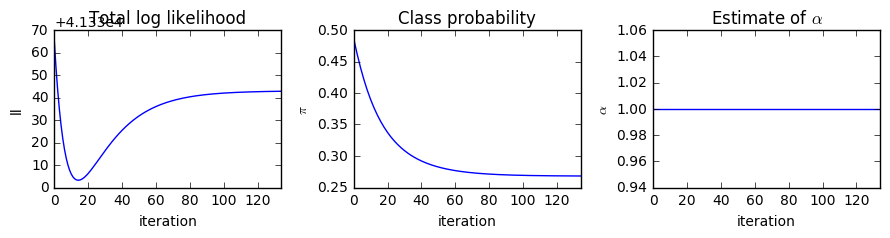

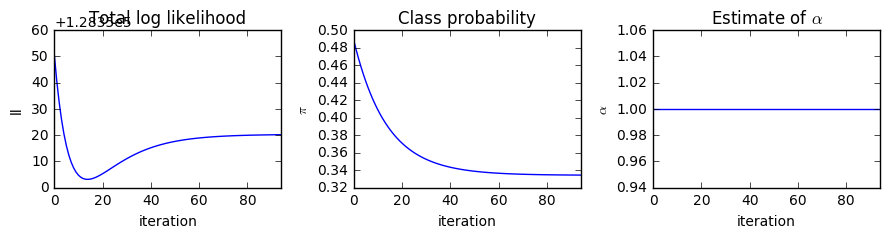

In [368]:
m6a = logit.MixedLogitModel('g-1.00-0.25-00.csv', grouped=False, vvv=1, rescale_samples=False)
m6a.add_log_degree_model(bounds=((1, 1),))  # clamped at 1 (full PA)
m6a.add_uniform_degree_model()
T6a = m6a.fit(etol=0.01, n_rounds=200, return_stats=True)
res_plot(T6a)

m6b = logit.MixedLogitModel('g-1.00-0.25-00.csv', grouped=False, vvv=1, rescale_samples=True)
m6b.add_log_degree_model(bounds=((1, 1),))  # clamped at 1 (full PA)
m6b.add_uniform_degree_model()
T6b = m6b.fit(etol=0.01, n_rounds=200, return_stats=True)
res_plot(T6b)

In [357]:
import imp
logit = imp.reload(logit)
util = imp.reload(util)
logit_individual = imp.reload(logit_individual)
LogDegreeModel = logit_individual.LogDegreeModel
